In [20]:
import pyart
import fsspec
import xarray as xr
import xradar as xd
import boto3
import botocore
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from botocore.client import Config
from datetime import datetime
from matplotlib import pyplot
pyplot.style.use('dark_background')

In [2]:
def create_query(date, radar_site):
    """
    Creates a query for listing IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a
    """
    prefix = f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'
    return prefix

In [21]:
str_bucket = 's3://s3-radaresideam/'

s3 = boto3.resource('s3',
                    config=Config(signature_version=botocore.UNSIGNED, 
                                  user_agent_extra='Resource'))

bucket = s3.Bucket('s3-radaresideam')

query = create_query(date=datetime(2022, 10, 6), radar_site='Guaviare')

radar_files = [f'{str_bucket}{i.key}' for i in bucket.objects.filter(Prefix=f"{query}")]

radar_files[:10]

['s3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000012.RAWHDKV',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000116.RAWHDL6',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000248.RAWHDL9',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000327.RAWHDLH',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000432.RAWHDLL',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000507.RAWHDLV',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000611.RAWHDM3',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000744.RAWHDMB',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000848.RAWHDMH',
 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/GUA221006000924.RAWHDMK']

## Using context manager and Pyart for reading radar data from guaviare radar


In [4]:
# using context manager for reading radar data from guaviare radar
of = pyart.io.prepare_for_read(radar_files[0], storage_options={'anon': True})
with of as f:
    radar = pyart.io.read(f)
    f.close()

In [5]:
radar.fields['reflectivity']

{'units': 'dBZ',
 'standard_name': 'equivalent_reflectivity_factor',
 'long_name': 'Reflectivity',
 'coordinates': 'elevation azimuth range',
 'data': masked_array(
   data=[[--, 3.5, 5.0, ..., --, --, --],
         [5.0, 6.5, 7.5, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, 1.5, --, ..., --, --, --],
         [1.5, -3.0, 3.5, ..., --, --, 7.5],
         [0.5, 0.0, 3.0, ..., --, --, --]],
   mask=[[ True, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True, False,  True, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True, False],
         [False, False, False, ...,  True,  True,  True]],
   fill_value=1e+20,
   dtype=float32),
 '_FillValue': -9999.0}

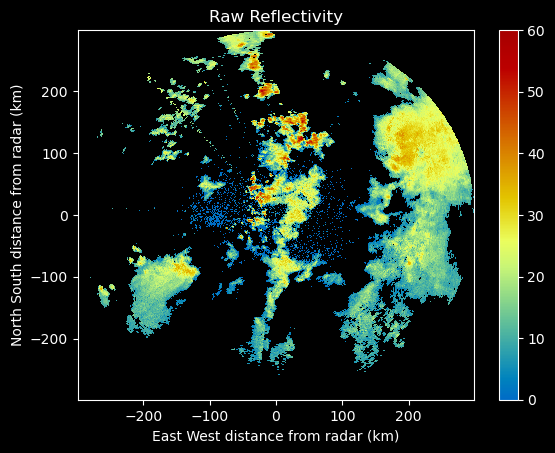

In [6]:
## Using cartesian cordinates
fig, ax = plt.subplots()
display = pyart.graph.RadarDisplay(radar)
display.plot('reflectivity', 0, ax=ax, vmin=0, vmax=60.,
             colorbar_label='', title='Raw Reflectivity')

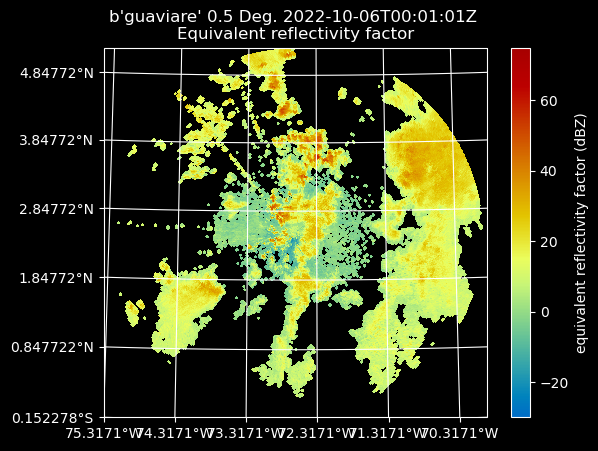

In [7]:
## Using geographic cordinates

disp1 = pyart.graph.RadarMapDisplay(radar)
disp1.plot_ppi_map('reflectivity',
                   sweep=0, 
                   min_lat=radar.gate_latitude['data'].min(),
                   max_lat=radar.gate_latitude['data'].max(),
                   min_lon=radar.gate_longitude['data'].min(),
                   max_lon=radar.gate_longitude['data'].max(),
                   lat_lines=np.arange(radar.gate_latitude['data'].min(),radar.gate_latitude['data'].max(), 1),
                   lon_lines=np.arange(radar.gate_longitude['data'].min(),radar.gate_longitude['data'].max(), 1))

## Using file-system reference FSSPEC and xradar for reading radar data from guaviare radar

In [8]:
file = fsspec.open_local(f'simplecache::{radar_files[0]}', s3={'anon': True}, filecache={'cache_storage': '.'})
ds = xr.open_dataset(file, engine="iris", group="sweep_0")

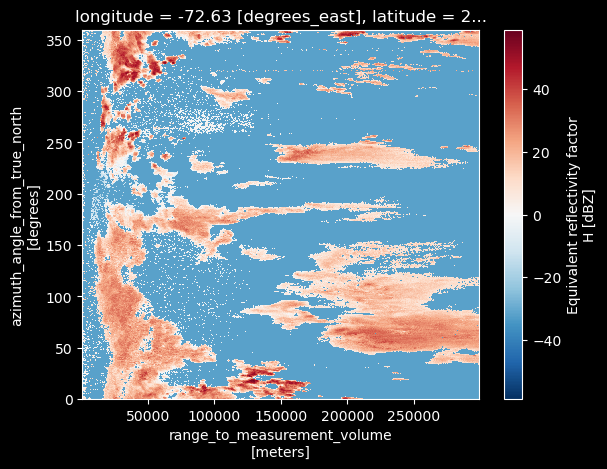

In [9]:
ds.DBZH.plot()

In [10]:
ds = xd.georeference.get_x_y_z(ds)

In [11]:
ds

<xarray.Dataset>
Dimensions:            (azimuth: 720, range: 994)
Coordinates:
  * azimuth            (azimuth) float64 0.02747 0.5191 1.024 ... 359.0 359.5
    elevation          (azimuth) float64 0.4834 0.4834 0.4834 ... 0.4834 0.4834
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    x                  (azimuth, range) float64 0.4794 0.6232 ... -2.491e+03
    y                  (azimuth, range) float64 1e+03 1.3e+03 ... 2.987e+05
    z                  (azimuth, range) float64 8.496 11.07 ... 7.777e+03
Data variables: (12/17)
    DBTH               (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    ...                 ...
    DB_DBZE8           (azimuth, range) int16 ...
    sweep_mode         <U20 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

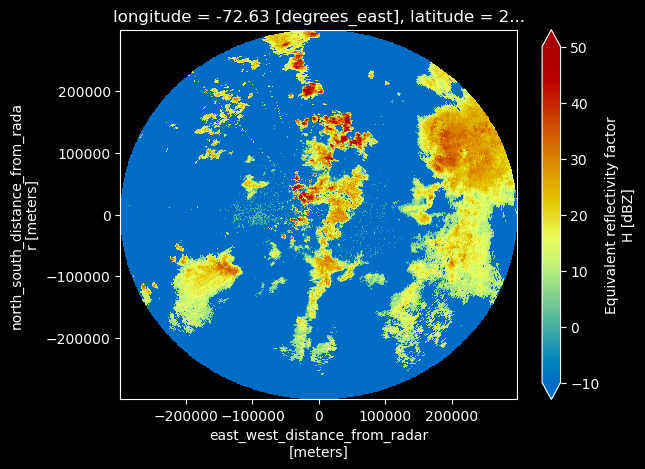

In [12]:
ds.DBZH.plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=-10, vmax=50)

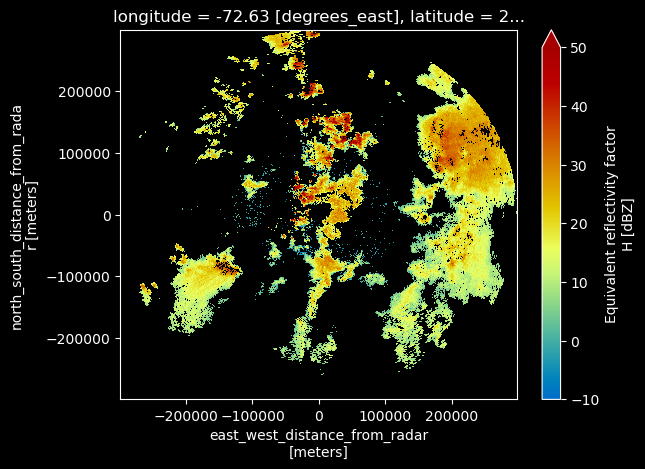

In [13]:
ds.DBZH.where(ds.DBZH > -10).where(ds.RHOHV > 0.95).plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=-10, vmax=50)

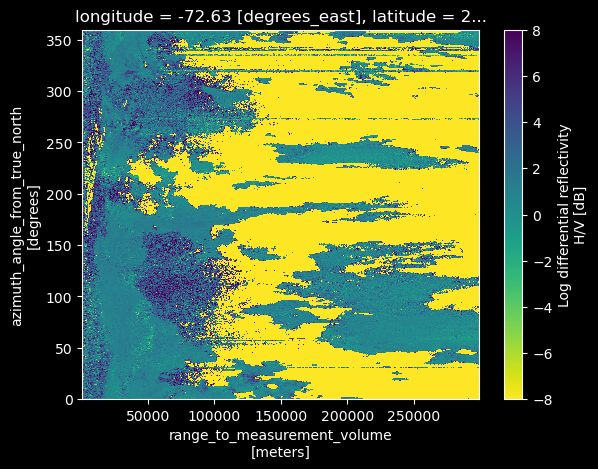

In [14]:
ds.ZDR.plot(cmap='viridis_r')

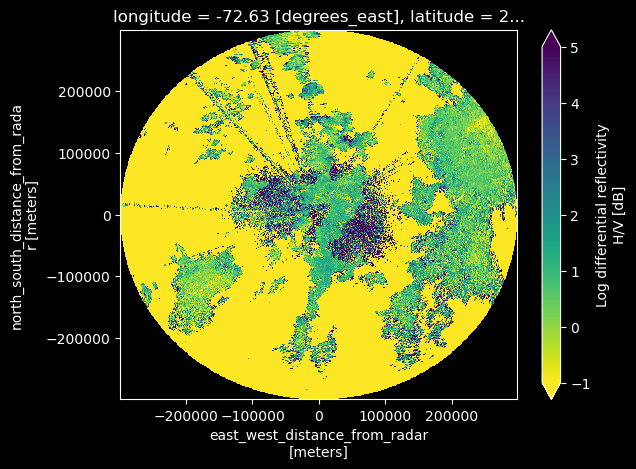

In [15]:
ds.ZDR.plot(x='x', y='y', vmin=-1, vmax=5, cmap='viridis_r')

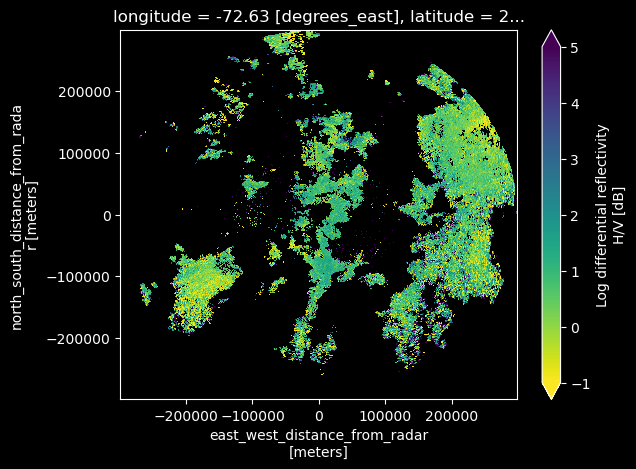

In [16]:
ds.ZDR.where(ds.DBZH > -10).where(ds.RHOHV > 0.95).plot(x='x', y='y', vmin=-1, vmax=5, cmap='viridis_r')

In [17]:
query = create_query(date=datetime(2022, 11, 29), radar_site='Tablazo')

radar_files = [f'{str_bucket}{i.key}' for i in bucket.objects.filter(Prefix=f"{query}")]


In [18]:
file = fsspec.open_local(f'simplecache::{radar_files[0]}', s3={'anon': True}, filecache={'cache_storage': '.'})
ds = xr.open_dataset(file, engine="iris", group="sweep_1")

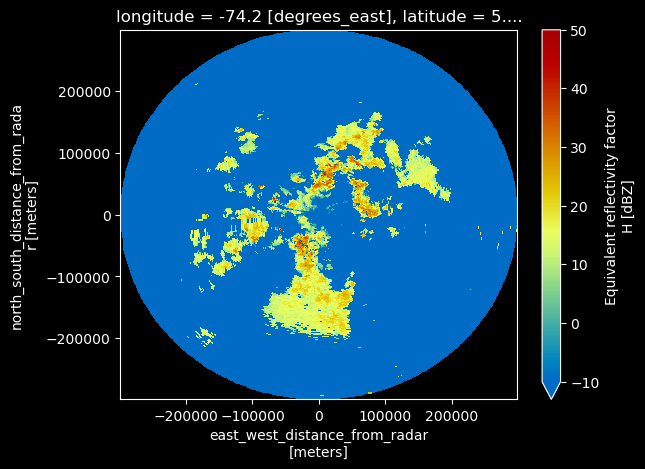

In [19]:
ds = xd.georeference.get_x_y_z(ds)
ds.DBZH.plot(x='x', y='y', cmap='pyart_HomeyerRainbow', vmin=-10, vmax=50)